In [1]:
import pandas as pd
import os

# DATASET FROM: http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# GF TODO: check if excel present, otherwise download it
# wget http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx

excel_with_path  = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.xlsx'
pickle_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.pkl'
csv_with_path = '/eos/user/f/franzoni/SWAN_projects/proton/online_retail_II.csv'

df = None

if os.path.isfile(pickle_with_path):
    print('-> picke already exists, much faster using it than opening excel files\n')
    df = pd.read_pickle(pickle_with_path)
else:
    print('-> picke does not exist, go to excel, and create it\n')
    df1 = pd.read_excel (excel_with_path,'Year 2009-2010')
    df2 = pd.read_excel (excel_with_path,'Year 2010-2011')
    df = pd.concat([df1, df2])
    df.to_pickle(pickle_with_path)

-> picke already exists, much faster using it than opening excel files



In [2]:
# define transaction: total cash for a single 'row' of the dataset, i.e. item_price times the number of items bought
df['Transaction'] = df.Quantity * df.Price
df=df.rename(columns={"Customer ID": "Customer_ID"})

# day, week and time are added for convenience of analysis later on
from datetime import datetime
df['InvoiceDay'] = df['InvoiceDate'].map(lambda p: p.date())
df['InvoiceWeekDay'] = df['InvoiceDate'].map(lambda p: p.weekday())
df['InvoiceTime'] = df['InvoiceDate'].map(lambda p: p.time())
df['InvoiceWeek'] = df['InvoiceDate'].map(lambda p: p.isocalendar()[1]+52*(p.year-2010))

# avoide negative weeks and start counting from the first week of the dataset, which starts from 01/12/2009
df['InvoiceWeek'] = df['InvoiceWeek']+3


# implement the definition of cancellation in the documentation:
# http://archive.ics.uci.edu/ml/datasets/Online+Retail+II
#      ==> "If this code starts with the letter 'c', it indicates a cancellation.""
def is_cancellation(s):
    if isinstance(s, int):
        #print "ordinary invoice"
        return 0
    elif isinstance(s, unicode):
        #print "unicode string"
        #thse are cancellations
        if s.rfind('C')!=-1:
            return 1
        else:
            # print "Something unexpected"  # found, e.g. A506401
            # print s
            return 2
df['IsCancellation'] = df['Invoice'].map(is_cancellation)     
      


# items with prices above ~1500 are so few that is worth looking at them in detail, and excluding them from the plots
# There'a lot of transactions with price set to 0, which based on the descriptions are 
max_item_price=1400
r             =(0,max_item_price)
def is_ordinary_item(p):
    if abs(p)>max_item_price or p==0:
        return 0
    else:
        return 1
df['IsOrdinaryItem'] = df['Price'].map(is_ordinary_item)        

# df.to_csv(csv_with_path, encoding = 'utf-8')

In [3]:
# what are the nulls in each feature?
nulls = df.isnull().sum()[df.isnull().sum() != 0]

# select all transactions containing 
df_nulls = df[df.isnull().any(axis=1)].copy(deep=True)

nulls_rel = nulls/df.shape[0]*100

nulls_summary = pd.concat([nulls, nulls_rel], axis=1, keys=['nulls', 'rel. nulls [%]'])\
               .sort_values('nulls', ascending=False)

nulls_summary

,nulls,rel. nulls [%]
Customer_ID,243007,22.766873
Description,4382,0.410541


#<a id='the_destination'></a>

## todo
- nan and empty -> cleanup   # IN THE MAKING -> only consequences on the users study
- add colums for data and time, separately ?    # DONE
- create a second DF by user: RFM added to


## What do I want to extract from this dataset?
- https://en.wikipedia.org/wiki/Exploratory_data_analysis

- how many customers   DONE, also as a function of country
- make a pliot of transaction, of purchase prices, and of invoice_price! #  DONE

- VS TIME: trends of spending overall, by country
- revenue as a function of date, as a function of the time in the day  # DONE
- trends of spending: overall, by the largest customer, by the smaller customers (TOO SPECIFIC?)

- NEED TO BUILD A PER CUSTOMER DF
- customer: how many transactions, how much total revenue:
    => BREAK DOWN BY country, tra
- RMF


- ==> do this
- how many different types of items                  # DONE
- what kind of items are bought the most (by NUMBER of by REVENUE), are cancelled the most, 
- how much revenue per type of item bought

- correlation between
- cancellations: fraction of cancellation by nunber of transactions and by proportion of renenue
-                correlation to CHURNING ? Correlation to country OR type of good purchased ?

- cust.groupby('customer_unique_id').size().value_counts() => The majority of customers made only a single purchase. # DONE


- Can I cathegorise the purchasable items? => If so, customers split across those cathegories
- Persona; how many cheap items, few expensive ones?
- https://cxl.com/blog/creating-customer-personas-using-data-driven-research/
- now many items are bought per session, how much is spent per session

==> TOWARDS CUSTOMER PERSONA DEFINITION
- MANY TRANSACTIONS ARE RECORDED AT THE SAME TIME => as if they were a single shopping session, but billed in split goups of goods
- the function summary_data_from_transaction_data treats transactions taking place on the same day as A SINGLE ONE!

---
<a id="section_ID_GF"></a>

- this section can be reached at this URL https://swan001.cern.ch/user/franzoni/notebooks/SWAN_projects/proton/proton-EDA.ipynb#section_ID_GF
- thanks to this documentation

<a id="section_customers"></a>
## Customers carachteristics

## plan for customers
- make a dataframe
- add also the RFM variables
- add nuber of items bought in total, number of different TYPEs of items
- add total value of course
- Can I cathegorise the purchasable items? => If so, customers split across those cathegories
- Persona; how many cheap items, few expensive ones?
- https://cxl.com/blog/creating-customer-personas-using-data-driven-research/

- DF to containg:
- filter out non standard AND null customers SHALL I REMOVE CANCELLATIONS ????? => yes, keep it basic for now!   DONE
- RFM
- PER TOTAL:    number of items per customer, number of DIFFERENT/unique items per customer             DONE
- PER INVOICE:  same-as-above  - DEFERED
- What's the number of orders/invoices per customer? DONE
- number of items per purchase, amount per purchase - of each different customer (do I alraedy have this ?)

+ RFM ANALYSIS:
- ==> add to the dataframe the quantiles of RFM, with the correct ordering/SCORE
- https://joaocorreia.io/blog/rfm-analysis-increase-sales-by-segmenting-your-customers.html
- https://www.blastanalytics.com/blog/rfm-analysis-boosts-sales

+ CLUSTERING
- https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_silhouette_method

<a id='the_destination'></a>

[Pippo goes to the cinema](section-title)

# Cleanup of data for customer analysis
- we decide to remove all datata points with no Customer_ID
- and to limit the study only to IsOrdinaryItem (as defined above), to avoid skewing the resuts w/ dataa points which are not actual purchases
- to keep the modelling basic, for now we decide also to remove all cancellation oders



In [4]:
df.shape

(1067371, 15)

In [5]:
df=df.dropna()

In [6]:
df.shape

(824364, 15)

In [7]:
df= df.loc[ (df.IsCancellation==0) & (df.IsOrdinaryItem==1) ]    

In [8]:
df.shape

(805520, 15)

In [9]:
df=df.sort_values(by=['InvoiceDate'],ascending=True)

# Basic customer integral features
- number of items bought trgought the entire period covered by data, indicating the overall commercial activity of each individual
- unique items, indicates the variety of the customers interests
- total amount spent by a customer
- number of invoices, i.e. how many times a customers surfaced and made an order

In [10]:
df_customer_items  = df.groupby('Customer_ID').StockCode.agg([len])     \
                         .rename(columns={"len": "items"})               \
                         .sort_values(by=['items'],ascending=False)

tit='Num items bought by customer'
r=(0,3000)
df_customer_items.plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

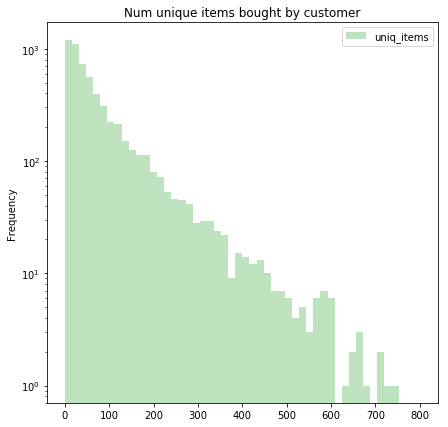

In [11]:
df_customer_uniq_items  = df.groupby('Customer_ID').StockCode.unique().agg([len])     \
                         .rename(columns={"len": "uniq_items"})               \
                         .sort_values(by=['uniq_items'],ascending=False)

tit='Num unique items bought by customer'
r=(0,800)
df_customer_uniq_items.plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

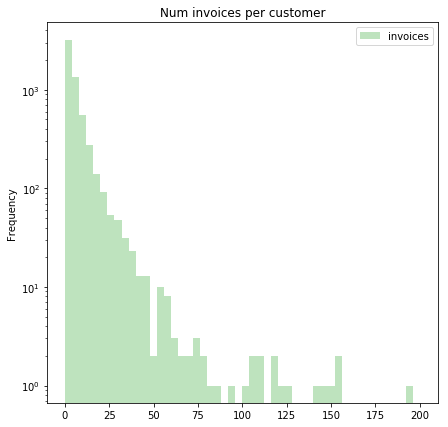

In [12]:
df_customer_invoices  = df.groupby('Customer_ID').Invoice.unique().agg([len])     \
                         .rename(columns={"len": "invoices"})               \
                         .sort_values(by=['invoices'],ascending=False)

tit='Num invoices per customer'
r=(0,200)
df_customer_invoices.plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

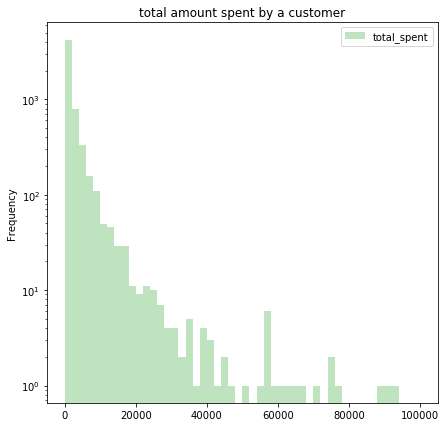

In [13]:
df_customer_spent = df.groupby('Customer_ID').Transaction.agg([sum])     \
                   .rename(columns={"sum": "total_spent"})               \
                   .sort_values(by=['total_spent'],ascending=False)

tit='total amount spent by a customer'
r=(0,100000)
df_customer_spent.plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

In [14]:
df_customer_spent.sort_values(by=['Customer_ID'],ascending=True).head()

,total_spent
Customer_ID,
12346.0,77556.46
12347.0,5633.32
12348.0,2019.40
12349.0,4428.69
12350.0,334.40


In [15]:
df.loc[ (df.Customer_ID==12346) &  (df.Quantity<100000)].Transaction.sum()

77556.46

In [16]:
df.loc[ (df.Customer_ID==12346)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Transaction,InvoiceDay,InvoiceWeekDay,InvoiceTime,InvoiceWeek,IsCancellation,IsOrdinaryItem
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346.0,United Kingdom,45.00,2009-12-14,0,08:34:00,2,0,1
28251,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.50,12346.0,United Kingdom,22.50,2009-12-14,0,11:00:00,2,0,1
28254,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.50,12346.0,United Kingdom,22.50,2009-12-14,0,11:02:00,2,0,1
39398,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,4.50,12346.0,United Kingdom,22.50,2009-12-18,4,10:47:00,2,0,1
39411,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.00,12346.0,United Kingdom,1.00,2009-12-18,4,10:55:00,2,0,1
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0,United Kingdom,22.50,2010-01-04,0,09:24:00,4,0,1
45230,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0,United Kingdom,22.50,2010-01-04,0,09:53:00,4,0,1
56117,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,4.50,12346.0,United Kingdom,22.50,2010-01-14,3,13:50:00,5,0,1
66084,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,4.50,12346.0,United Kingdom,22.50,2010-01-22,4,13:30:00,6,0,1
107803,499763,15056BL,EDWARDIAN PARASOL BLACK,1,2010-03-02 13:08:00,5.95,12346.0,United Kingdom,5.95,2010-03-02,1,13:08:00,12,0,1


In [17]:
df.loc[ (df.Customer_ID==12346)].InvoiceDay.unique().shape
# verification of 'fequency' being equal to 7 for 12346
# remiminder: the RFM variables exclude the first invoice

(8,)

# Historic customer  features
- **Recency**: How recently a customer has made a purchase
- **Frequency**: How often a customer makes a purchase
- **Monetary Value**: Average expenditure for an invoice

- note: RFM variables exlcude the first invoice for all customers. Only returning invoices are considered
- note2: values=0 are for customers that don't return => select those customers away to consider

In [18]:
data_star='2009-12-01'
calib_end='2011-05-31'
obser_end='2011-12-09'

from datetime import date
d_data_star=date( * map(lambda u:int(u), data_star.split('-') ) )
d_calib_end=date( * map(lambda u:int(u), calib_end.split('-') ) )
d_obser_end=date( * map(lambda u:int(u), obser_end.split('-') ) )

from lifetimes.utils import *

#    This transforms a DataFrame of transaction data of the form:
#        customer_id, datetime [, monetary_value]
#    to a DataFrame of the form:
#        customer_id, frequency, recency, T [, monetary_value]

df_customer_RFM = summary_data_from_transaction_data(df.sort_values(by=['InvoiceDate'],ascending=True)
                                                     ,'Customer_ID','InvoiceDate'
                                                     ,monetary_value_col='Transaction'
                                                     ,freq='D'
                                                     #,observation_period_end=obser_end
                                                    )

In [19]:
df_customer_RFM.head()

,frequency,recency,T,monetary_value
Customer_ID,,,,
12346.0,7.0,400.0,725.0,11066.637143
12347.0,7.0,402.0,404.0,717.398571
12348.0,4.0,363.0,438.0,449.310000
12349.0,3.0,571.0,589.0,1120.056667
12350.0,0.0,0.0,310.0,0.000000


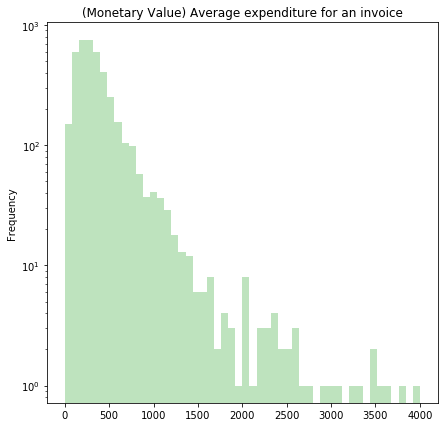

In [20]:
tit='(Monetary Value) Average expenditure for an invoice'
r=(0,4000)
df_customer_RFM['monetary_value'].loc[df_customer_RFM['monetary_value']>0]  \
                                 .plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

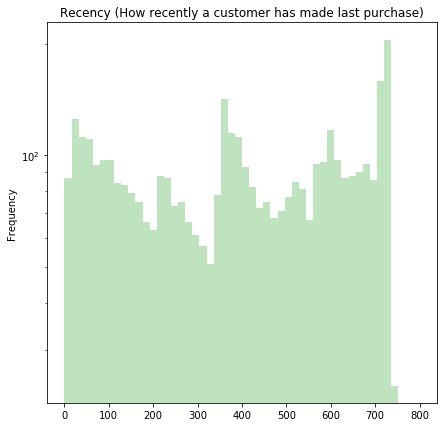

In [21]:
tit='Recency (How recently a customer has made last purchase)'
r=(0,800)
df_customer_RFM['recency'].loc[df_customer_RFM['recency']>0] \
     .plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

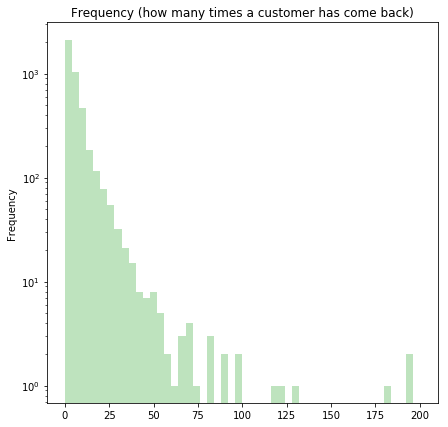

In [22]:
tit='Frequency (how many times a customer has come back)'
r=(0,200)
df_customer_RFM['frequency'].loc[df_customer_RFM['frequency']>0] \
           .plot(kind='hist',logy=True,title=tit,bins=50,range=r,colormap='Accent',alpha=0.5,figsize=(7,7))

In [23]:
df_customer = df_customer_items     \
                .join(df_customer_invoices)    \
                .join(df_customer_spent)   \
                .join(df_customer_RFM)   \
            .sort_values(by=['total_spent'],ascending=False)

df_customer.shape
df_customer.head()

,items,invoices,total_spent,frequency,recency,T,monetary_value
Customer_ID,,,,,,,
18102.0,1058,145,608821.65,66.0,738.0,738.0,9189.930455
14646.0,3849,151,528602.52,90.0,736.0,737.0,5809.905333
14156.0,4046,154,308664.36,119.0,729.0,738.0,2584.853445
14911.0,11243,396,292598.29,253.0,737.0,738.0,1153.615257
17450.0,424,51,246973.09,30.0,430.0,438.0,6924.523000


In [24]:
df_customer.shape

(5875, 7)

In [25]:
df_customer = df_customer.loc[df_customer['frequency']>0]   \
                    .loc[df_customer['recency']>0]          \
                    .loc[df_customer['frequency']>0]        \


In [26]:
df_customer.shape

(4188, 7)

In [27]:
# cut_out=0.02
# q_low = df_customer["monetary_value"].quantile(cut_out)
# q_hi  = df_customer["monetary_value"].quantile(1-cut_out)
# df_customer = df_customer[(df_customer["monetary_value"] < q_hi) & (df_customer["monetary_value"] > q_low)]
# df_customer.shape

In [28]:
df_customer.corr()

,items,invoices,total_spent,frequency,recency,T,monetary_value
items,1.000000,0.798900,0.460331,0.801204,0.292752,0.176818,0.027191
invoices,0.798900,1.000000,0.624470,0.966786,0.377029,0.249447,0.033921
total_spent,0.460331,0.624470,1.000000,0.548049,0.187716,0.122081,0.249806
frequency,0.801204,0.966786,0.548049,1.000000,0.423773,0.273822,0.023363
recency,0.292752,0.377029,0.187716,0.423773,1.000000,0.710618,0.009709
T,0.176818,0.249447,0.122081,0.273822,0.710618,1.000000,-0.007027
monetary_value,0.027191,0.033921,0.249806,0.023363,0.009709,-0.007027,1.000000


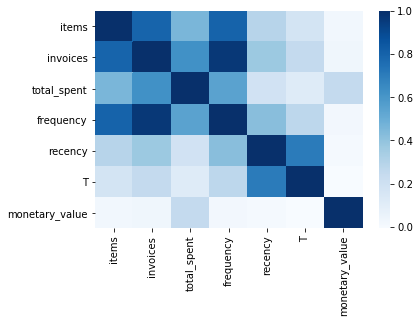

In [29]:
import seaborn as sns

sns.heatmap(df_customer.drop([],axis=1).corr(),cmap="Blues")

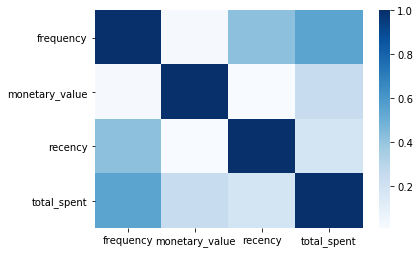

In [40]:
sns.heatmap(df_customer[['frequency','monetary_value','recency','total_spent']].corr(),cmap="Blues")

In [44]:
# Importing the dataset
#df_customer_km = df_customer.drop(['Customer_ID'],axis=0)

mat_customer_km = df_customer[['frequency','recency','monetary_value','total_spent']]
mat_customer_km.head()

,frequency,recency,monetary_value,total_spent
Customer_ID,,,,
18102.0,66.0,738.0,9189.930455,608821.65
14646.0,90.0,736.0,5809.905333,528602.52
14156.0,119.0,729.0,2584.853445,308664.36
14911.0,253.0,737.0,1153.615257,292598.29
17450.0,30.0,430.0,6924.523000,246973.09


('For n_clusters =', 2, 'The average silhouette_score is :', 0.9838331572331146)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.97118522113008)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.9416915789380231)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.8291428695202634)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.7983862576573459)
('For n_clusters =', 7, 'The average silhouette_score is :', 0.8003581575252952)
('For n_clusters =', 8, 'The average silhouette_score is :', 0.7221811624928178)
('For n_clusters =', 9, 'The average silhouette_score is :', 0.6585894534055113)
('For n_clusters =', 10, 'The average silhouette_score is :', 0.6581226626249155)


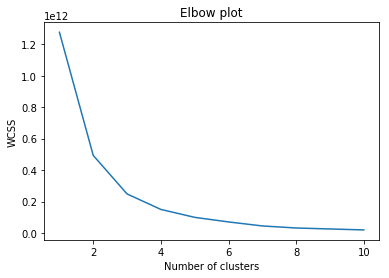

In [45]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score

wcss = []
mat_customer_km = mat_customer_km.as_matrix()

import matplotlib.pyplot as plt

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(mat_customer_km)
    clusters = kmeans.predict(mat_customer_km)
    if i>1:
        silhouette_avg = silhouette_score(mat_customer_km, clusters)
        print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('Elbow plot')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

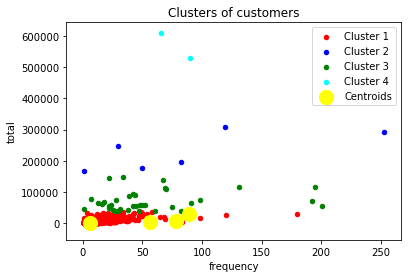

In [50]:
X=mat_customer_km
# Fitting K-Means to the dataset
how_many_clusters = 4
kmeans = KMeans(n_clusters = how_many_clusters, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)


# 0: frequency
# 1: recency
# 2: value
# 3: total
labels = ['frequency','recency','value','total']
x_index=0
y_index=3
# Visualising the clusters
plt.scatter(X[y_kmeans == 0, x_index], X[y_kmeans == 0, y_index], s = 20, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, x_index], X[y_kmeans == 1, y_index], s = 20, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, x_index], X[y_kmeans == 2, y_index], s = 20, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3, x_index], X[y_kmeans == 3, y_index], s = 20, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_kmeans == 4, x_index], X[y_kmeans == 4, y_index], s = 20, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s = 200, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel(labels[x_index])
plt.ylabel(labels[y_index])
plt.legend()
plt.show()

In [53]:
type(y_kmeans)

numpy.ndarray

In [34]:
# freq
X[:,0]

array([ 66.,  90., 119., ...,   1.,   3.,   1.])

In [35]:
# recency
X[:,1]

array([738., 736., 729., ..., 192., 567., 119.])

In [36]:
# value
X[:,2]

array([9189.93045455, 5809.90533333, 2584.85344538, ...,   15.44      ,
          9.8       ,   10.9       ])

In [37]:
X[0,:]

array([  66.        ,  738.        , 9189.93045455])